In [ ]:
import sklearn as sk
import numpy as np
import pandas as pd
import json


class BQDataset():
    def __init__(self, path):
        self.dataset = open(path,encoding="utf-8")

        self.dataset = [json.loads(instance) for instance in self.dataset ]


        self.passages = []
        self.questions = []
        self.answers = []
        self.titles = []

        for inst in self.dataset:
            self.passages.append(inst["passage"])
            self.questions.append(inst["question"])
            self.answers.append(inst["answer"])
            self.titles.append(inst["title"])

    def get_dataset(self):
        return self.dataset

    def get_split(self):

        return self.passages,self.questions, self.answers



### **Preprocessing**

In [ ]:
def clean(text, stem_words=True):
    import re    # for regular expressions
    from string import punctuation
    from nltk.stem import SnowballStemmer
    from nltk.corpus import stopwords


    text = re.sub("\'s", " ", text) 
    text = re.sub(" whats ", " what is ", text, flags=re.IGNORECASE)
    text = re.sub("\'ve", " have ", text)

    text = re.sub("can't", "cannot", text, flags=re.IGNORECASE)
    text = re.sub("don't", "do not", text, flags=re.IGNORECASE)
    text = re.sub("won't", "will not", text, flags=re.IGNORECASE)
    text = re.sub("shouldn't", "should not", text, flags=re.IGNORECASE)
    text = re.sub("couldn't", "could not", text, flags=re.IGNORECASE)
    text = re.sub("isn't", "is not", text, flags=re.IGNORECASE)
    text = re.sub("wasn't", "was not", text, flags=re.IGNORECASE)
    text = re.sub("weren't", "were not", text, flags=re.IGNORECASE)
    text = re.sub("haven't", "have not", text, flags=re.IGNORECASE)
    text = re.sub("hasn't", "has not", text, flags=re.IGNORECASE)
    text = re.sub("hadn't", "had not", text, flags=re.IGNORECASE)

    # remove comma between numbers, i.e. 15,000 -> 15000
    text = re.sub('(?<=[0-9])\,(?=[0-9])', "", text)

    # remove punctuation
    text = re.sub(r'[^\w\s]', ' ', text)

    text = re.sub(r' +', ' ', text)

    # Return a list of words
    return text


def tokenize(text):

    # Split by whitespace
    text = text.split(" ")

    return text

In [ ]:
# Apply pre-processing to data
import nltk
nltk.download("punkt")

bqd = BQDataset("train.jsonl")
dataset = bqd.get_dataset()
p,q,answers = bqd.get_split()

questions = []
passages = []
for i in range(len(p)):

    p_ = clean(p[i])
    p_ = nltk.tokenize.word_tokenize(p_)

    q_ = clean(q[i])
    q_ = nltk.tokenize.word_tokenize(q_)

    passages.append(p_)
    questions.append(q_)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
for i in range(10):
  print(passages[i][:15])
  print(questions[i])
  print(answers[i])

['Persian', 'ˈpɜːrʒən', 'ʃən', 'also', 'known', 'by', 'its', 'endonym', 'Farsi', 'فارسی', 'fārsi', 'fɒːɾˈsiː', 'listen', 'is', 'one']
['do', 'iran', 'and', 'afghanistan', 'speak', 'the', 'same', 'language']
True
['Good', 'Samaritan', 'laws', 'offer', 'legal', 'protection', 'to', 'people', 'who', 'give', 'reasonable', 'assistance', 'to', 'those', 'who']
['do', 'good', 'samaritan', 'laws', 'protect', 'those', 'who', 'help', 'at', 'an', 'accident']
True
['Windows', 'Movie', 'Maker', 'formerly', 'known', 'as', 'Windows', 'Live', 'Movie', 'Maker', 'in', 'Windows', '7', 'is', 'a']
['is', 'windows', 'movie', 'maker', 'part', 'of', 'windows', 'essentials']
True
['Powdered', 'sugar', 'also', 'called', 'confectioners', 'sugar', 'icing', 'sugar', 'and', 'icing', 'cake', 'is', 'a', 'finely', 'ground']
['is', 'confectionary', 'sugar', 'the', 'same', 'as', 'powdered', 'sugar']
True
['As', 'with', 'other', 'games', 'in', 'The', 'Elder', 'Scrolls', 'series', 'the', 'game', 'is', 'set', 'on', 'the']
['

### Baseline Model

In [ ]:
from sklearn.model_selection import *
from sklearn.metrics import *
class BaselineModel:


    def __init__(self, w2v_model,embedding_size, P,Q,A,seed = 0):

        self.w2v = w2v_model
        self.embedding_size = embedding_size
        self.P = P
        self.Q = Q
        self.A = A

        self.X, self.y = self.get_X_y(self.P,self.Q,self.A,embedding_size,self.w2v)

        self.X_train, self.X_dev, self.y_train, self.y_dev = sk.model_selection.train_test_split(self.X,self.y,random_state=seed,shuffle=True,train_size=0.7)

    def get_X_y(self,P,Q,A, embedding_size, w2v):

        X = []
        y = []
        for i in range(len(P)):

            p_ = P[i]
            q_ = Q[i]

            p_vect = np.zeros(embedding_size)
            q_vect = np.zeros(embedding_size)

            for word in p_:
                if word in w2v.wv.key_to_index:

                    p_vect += w2v.wv.get_vector(word)

            for word in q_:
                if word in w2v.wv.key_to_index:
                    q_vect += w2v.wv.get_vector(word)


            p_vect /= len(p_)
            q_vect /= len(q_)

            X.append(np.concatenate([p_vect,q_vect]))
            y.append(0 if A[i] == False else 1)

        return X,y


    def evaluate(self, classifier, name = "None"):

        classifier.fit(self.X_train,self.y_train)

        train_score = f1_score(self.y_train,classifier.predict(self.X_train))
        dev_score = f1_score(self.y_dev,classifier.predict(self.X_dev))

        print(f"MODEL: {name}")
        print(f"f1-score for train set: {train_score}")
        print(f"f1-score for dev set: {dev_score}")
        print(f"classification dev set report \n: {classification_report(self.y_dev,classifier.predict(self.X_dev))}")






In [ ]:
from gensim.models import Word2Vec
from sklearn.linear_model import *


embedding_size = 100


sentences = []
for i in range(len(passages)):
    temp = passages[i]
    temp.extend(questions[i])
    sentences.append(temp)



In [ ]:
w2v_model = Word2Vec(sentences=sentences,vector_size=embedding_size, window= 5, min_count= 1, workers= 4)
classifier = LogisticRegression(penalty="l2",max_iter=10000)


w2v_model.train(sentences,total_examples=len(sentences),epochs=10)


(7724736, 9761970)

In [ ]:
k = BaselineModel(w2v_model,embedding_size,passages,questions,answers)
k.evaluate(classifier,"Logistic Regression")
svm = sk.svm.SVC(class_weight = "balanced",max_iter = 40000,C = 15)
k.evaluate(svm,"Support Vector Machine")

MODEL: Logistic Regression
f1-score for train set: 0.7716686163990216
f1-score for dev set: 0.751819322459222
classification dev set report 
:               precision    recall  f1-score   support

           0       0.59      0.31      0.41      1097
           1       0.66      0.86      0.75      1732

    accuracy                           0.65      2829
   macro avg       0.63      0.59      0.58      2829
weighted avg       0.64      0.65      0.62      2829

MODEL: Support Vector Machine
f1-score for train set: 0.929717626570469
f1-score for dev set: 0.7003525264394829
classification dev set report 
:               precision    recall  f1-score   support

           0       0.53      0.56      0.55      1097
           1       0.71      0.69      0.70      1732

    accuracy                           0.64      2829
   macro avg       0.62      0.63      0.62      2829
weighted avg       0.64      0.64      0.64      2829



### **The LSTM Model**

In [ ]:
import numpy as np
import tensorflow as tf
import sklearn as sk
import pandas as pd
from sklearn.model_selection import *
from sklearn.metrics import *

BUFFER_SIZE = 10000
BATCH_SIZE = 64

passages = []
questions = []
answers = []

for line in dataset:

    passages.append(clean(line["passage"]))
    questions.append(clean(line["question"]))
    answers.append(line["answer"])


In [ ]:
# Splitting the data into train and development sets
X = []
for i in range(len(passages)):
    X.append(passages[i] + " __SEP__ " +  questions[i])

seed = 42
X_train, X_dev, y_train, y_dev = sk.model_selection.train_test_split(X,answers,random_state=seed,shuffle=True,train_size=0.7)
y_train = [1 if y else 0 for y in y_train]
y_dev = [1 if y else 0 for y in y_dev]

print(X_train[1]) # For testing

# Here we are putting the data into a tensorflow dataset so that we can use it with the enconder to vectorize it.
X_train_tf = tf.data.Dataset.from_tensor_slices(X_train) # To encode the vectors for the training set
# X_dev_tf = tf.data.Dataset.from_tensor_slices(X_dev) # To encode the vectors for the development set


Within the ADIZ is an even more sensitive zone designated the Washington D C Metropolitan Area Flight Restricted Zone DC FRZ The DC FRZ extends approximately 13 15 nmi 15 17 mi 24 28 km around the DCA VOR DME Flight within the FRZ is restricted to governmental certain scheduled commercial and a limited set of waivered flights Three general aviation airports known as the Maryland 3 or the DC 3 are located inside the DC FRZ College Park Airport CGS Washington Executive Hyde Field W32 and Potomac Airport VKX  __SEP__ are planes allowed to fly over washington dc


In [ ]:
print(X[0])

Persian ˈpɜːrʒən ʃən also known by its endonym Farsi فارسی fārsi fɒːɾˈsiː listen is one of the Western Iranian languages within the Indo Iranian branch of the Indo European language family It is primarily spoken in Iran Afghanistan officially known as Dari since 1958 and Tajikistan officially known as Tajiki since the Soviet era and some other regions which historically were Persianate societies and considered part of Greater Iran It is written in the Persian alphabet a modified variant of the Arabic script which itself evolved from the Aramaic alphabet  <SEP> do iran and afghanistan speak the same language


In [ ]:
# Encoding the X_train data only to encode the word vectors then we use X_train on the model


print(type(X)) # For testing
print(type(y_train)) # For testing

encoder = tf.keras.layers.TextVectorization() # Splits on whitespace by default
encoder.adapt(X_train_tf.batch(64))

vocab = np.array(encoder.get_vocabulary())


<class 'list'>
<class 'list'>


In [ ]:
print("vocab size: ",len(vocab))

vocab size:  36383


In [ ]:
def get_LSTM_model(encoder,embedding_size = 100, dim = 100,lstm_cnt = 1,post_lstm_dense_cnt = 1, dropout = 0.2):

  lstm_layers = [tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(dim,dropout = dropout,return_sequences=True)) for i in range(lstm_cnt-1)]
  lstm_layers.append(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(dim,dropout = dropout,return_sequences=False)))

  layers = [encoder,
            tf.keras.layers.Embedding( input_dim=len(vocab), output_dim=embedding_size,mask_zero=True),
            ]
  layers.extend(lstm_layers)

  for i in range(post_lstm_dense_cnt):
    layers.append(tf.keras.layers.Dense(dim, activation='tanh'))
    layers.append(tf.keras.layers.Dropout(dropout))

  layers.append(tf.keras.layers.Dense(1,activation='sigmoid'))

  model = tf.keras.Sequential(layers)

  return model


In [ ]:
# Building the model
# We are using the X_train data to train the model, X_train_tf is only used to encode the word vectors.


lstm_cnts = [1,2,3]

for lstm_cnt in lstm_cnts:
  model = get_LSTM_model(encoder,embedding_size = 128,dim = 128,lstm_cnt = lstm_cnt, post_lstm_dense_cnt=1,dropout = 0.3) 

  model.compile(loss="mse",
                optimizer=tf.keras.optimizers.Adam(1e-4),
                metrics=['accuracy'])

  # Training the model on the training set
  model.fit(X_train, y_train, epochs=15,batch_size=40, verbose = 1)

  # Save the model
  model_path = "saved_model_"+str(lstm_cnt)
  model.save(model_path)

  print("LSTM LAYER CNT: ",lstm_cnt)

  k  = model.predict(X_train, verbose = 0)
  k = [0 if i <= 0.5 else 1 for i in k ]
  print("TRAIN REPORT:")
  print(classification_report(y_train,k))
  print(f1_score(y_train,k))


  test_pred_cls = [0 if i <= 0.5 else 1 for i in test_pred]
  test_pred = model.predict(X_dev, verbose = 0)
  print("DEV REPORT:")
  print(f1_score(y_dev,test_pred_cls))
  print(classification_report(y_dev,test_pred_cls))


Epoch 1/15
165/165 [==============================] - 46s 214ms/step - loss: 0.2379 - accuracy: 0.6229
Epoch 2/15
165/165 [==============================] - 24s 144ms/step - loss: 0.2278 - accuracy: 0.6255
Epoch 3/15
165/165 [==============================] - 29s 178ms/step - loss: 0.1803 - accuracy: 0.7378
Epoch 4/15
165/165 [==============================] - 15s 90ms/step - loss: 0.1043 - accuracy: 0.8630
Epoch 5/15
165/165 [==============================] - 12s 74ms/step - loss: 0.0601 - accuracy: 0.9251
Epoch 6/15
165/165 [==============================] - 10s 58ms/step - loss: 0.0448 - accuracy: 0.9444
Epoch 7/15
165/165 [==============================] - 9s 52ms/step - loss: 0.0364 - accuracy: 0.9554
Epoch 8/15
165/165 [==============================] - 8s 48ms/step - loss: 0.0325 - accuracy: 0.9604
Epoch 9/15
165/165 [==============================] - 9s 56ms/step - loss: 0.0286 - accuracy: 0.9654
Epoch 10/15
165/165 [==============================] - 7s 43ms/step - loss: 0.0272

LSTM LAYER CNT:  1
TRAIN REPORT:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      2475
           1       0.98      0.99      0.99      4123

    accuracy                           0.98      6598
   macro avg       0.98      0.98      0.98      6598
weighted avg       0.98      0.98      0.98      6598

0.9863378067948253


NameError: ignored

In [ ]:
!zip -r saved_model_1.zip /content/saved_model_1

  adding: content/saved_model_1/ (stored 0%)
  adding: content/saved_model_1/variables/ (stored 0%)
  adding: content/saved_model_1/variables/variables.index (deflated 63%)
  adding: content/saved_model_1/variables/variables.data-00000-of-00001 (deflated 6%)
  adding: content/saved_model_1/keras_metadata.pb (deflated 90%)
  adding: content/saved_model_1/saved_model.pb (deflated 88%)
  adding: content/saved_model_1/fingerprint.pb (stored 0%)
  adding: content/saved_model_1/assets/ (stored 0%)


#### **Managing overfitting problem - Dropout**

In [ ]:

dropouts = [0,0.1,0.2,0.3,0.5]

train_f1s = []
dev_f1s = []

for dropout in dropouts:
  model = get_LSTM_model(encoder,embedding_size = 128,dim = 128,lstm_cnt = 1, post_lstm_dense_cnt=1,dropout = dropout) 

  model.compile(loss="mse",
                optimizer=tf.keras.optimizers.Adam(1e-4),
                metrics=['accuracy'])

  # Training the model on the training set
  model.fit(X_train, y_train, epochs=15,batch_size=40, verbose = 0)

  print("DROPOUT: ",dropout)

  k  = model.predict(X_train, verbose = 0)
  k = [0 if i <= 0.5 else 1 for i in k ]
  print("TRAIN REPORT:")
  print(classification_report(y_train,k))
  print(f1_score(y_train,k))
  train_f1s.append(f1_score(y_train,k))

  test_pred_cls = [0 if i <= 0.5 else 1 for i in test_pred]
  test_pred = model.predict(X_dev, verbose = 0)
  print("DEV REPORT:")
  print(f1_score(y_dev,test_pred_cls))
  print(classification_report(y_dev,test_pred_cls))
  dev_f1s.append(f1_score(y_dev,test_pred_cls))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


DROPOUT:  0
TRAIN REPORT:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      2475
           1       0.99      0.99      0.99      4123

    accuracy                           0.99      6598
   macro avg       0.99      0.99      0.99      6598
weighted avg       0.99      0.99      0.99      6598

0.9902114803625378
DEV REPORT:
0.7503983005841742
              precision    recall  f1-score   support

           0       0.58      0.44      0.50      1078
           1       0.70      0.81      0.75      1751

    accuracy                           0.67      2829
   macro avg       0.64      0.62      0.63      2829
weighted avg       0.66      0.67      0.66      2829

DROPOUT:  0.1
TRAIN REPORT:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      2475
           1       0.99      0.99      0.99      4123

    accuracy                           0.99      6598
   macro avg       0.99 

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


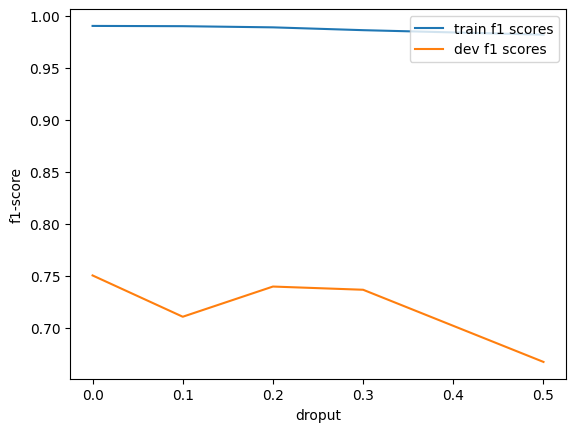

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.close()
plt.plot(dropouts,train_f1s,label = 'train f1 scores')
plt.plot(dropouts,dev_f1s,label = 'dev f1 scores')
plt.xlabel('droput')
plt.ylabel('f1-score')
plt.legend(loc = "upper right")
plt.show()


#### **Neuron Amount**

In [ ]:
neuron_cnts = [16,32,64,256]

train_f1s = []
dev_f1s = []

for d_model in neuron_cnts:
  model = get_LSTM_model(encoder,embedding_size = 128,dim = d_model,lstm_cnt = 1, post_lstm_dense_cnt=1,dropout = 0.2) 

  model.compile(loss="mse",
                optimizer=tf.keras.optimizers.Adam(1e-4),
                metrics=['accuracy'])

  # Training the model on the training set
  model.fit(X_train, y_train, epochs=15,batch_size=40, verbose = 0)

  print("Neuron CNT: ",d_model)

  k  = model.predict(X_train, verbose = 0)
  k = [0 if i <= 0.5 else 1 for i in k ]
  print("TRAIN REPORT:")
  print(classification_report(y_train,k))
  print(f1_score(y_train,k))
  train_f1s.append(f1_score(y_train,k))

  test_pred = model.predict(X_dev, verbose = 0)
  test_pred_cls = [0 if i <= 0.5 else 1 for i in test_pred]
  print("DEV REPORT:")
  print(f1_score(y_dev,test_pred_cls))
  print(classification_report(y_dev,test_pred_cls))
  dev_f1s.append(f1_score(y_dev,test_pred_cls))

Neuron CNT:  16
TRAIN REPORT:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      2475
           1       0.98      0.98      0.98      4123

    accuracy                           0.98      6598
   macro avg       0.98      0.98      0.98      6598
weighted avg       0.98      0.98      0.98      6598

0.9843503578794128
DEV REPORT:
0.7088750706613908
              precision    recall  f1-score   support

           0       0.52      0.51      0.51      1078
           1       0.70      0.72      0.71      1751

    accuracy                           0.64      2829
   macro avg       0.61      0.61      0.61      2829
weighted avg       0.63      0.64      0.63      2829

Neuron CNT:  32
TRAIN REPORT:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      2475
           1       0.98      0.99      0.99      4123

    accuracy                           0.98      6598
   macro avg      

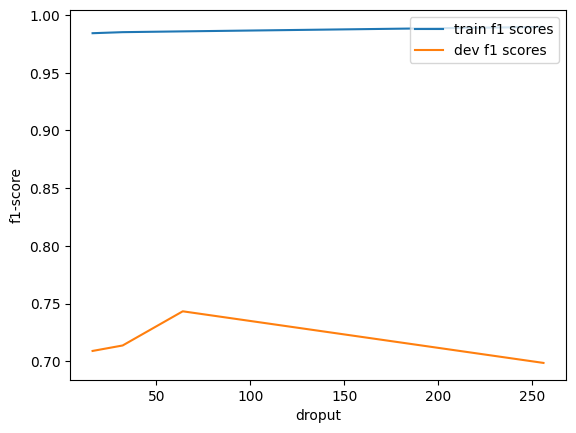

In [ ]:
import matplotlib.pyplot as plt

plt.plot(neuron_cnts,train_f1s,label = 'train f1 scores')
plt.plot(neuron_cnts,dev_f1s,label = 'dev f1 scores')
plt.xlabel('droput')
plt.ylabel('f1-score')
plt.legend(loc = "upper right")

### **Test Set Evaluation**

In [ ]:
bqd = BQDataset("dev.jsonl")
dataset = bqd.get_dataset()
p,q,answers = bqd.get_split()

X_test  = []
y_test = []
for i in range(len(answers)):

  y_test.append(1 if answers[i] else 0)

  X_test.append(clean(p[i]) + " __SEP__ " + clean(q[i]))

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight = "balanced", classes = [0,1], y = y_test)
class_weights = {i : class_weights[i] for i in range(len(class_weights))}

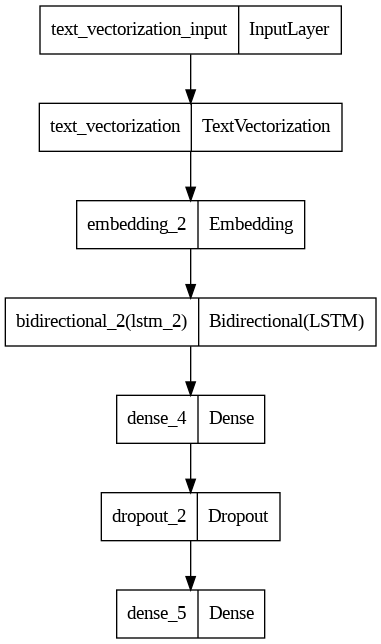

In [ ]:


final_model = get_LSTM_model(encoder,embedding_size = 128, dim = 64,lstm_cnt = 1,post_lstm_dense_cnt = 1, dropout = 0.2)
final_model.compile(loss="mse",
                optimizer=tf.keras.optimizers.Adam(1e-4),
                metrics=['accuracy'])

tf.keras.utils.plot_model(final_model)

In [ ]:
X_fin = np.concatenate((X_train,X_dev))
y_fin = np.concatenate((y_train,y_dev))

In [ ]:
final_model.fit(X_fin,y_fin,epochs = 15, batch_size = 40, class_weight = class_weights)

Epoch 1/15
236/236 [==============================] - 47s 160ms/step - loss: 0.2494 - accuracy: 0.5687
Epoch 2/15
236/236 [==============================] - 25s 105ms/step - loss: 0.2380 - accuracy: 0.6049
Epoch 3/15
236/236 [==============================] - 18s 77ms/step - loss: 0.1757 - accuracy: 0.7491
Epoch 4/15
236/236 [==============================] - 16s 66ms/step - loss: 0.1074 - accuracy: 0.8585
Epoch 5/15
236/236 [==============================] - 15s 63ms/step - loss: 0.0694 - accuracy: 0.9141
Epoch 6/15
236/236 [==============================] - 12s 52ms/step - loss: 0.0509 - accuracy: 0.9389
Epoch 7/15
236/236 [==============================] - 11s 46ms/step - loss: 0.0447 - accuracy: 0.9462
Epoch 8/15
236/236 [==============================] - 9s 40ms/step - loss: 0.0397 - accuracy: 0.9528
Epoch 9/15
236/236 [==============================] - 11s 46ms/step - loss: 0.0357 - accuracy: 0.9576
Epoch 10/15
236/236 [==============================] - 9s 38ms/step - loss: 0.033

In [ ]:
y_predict = final_model.predict(X_test)

y_cls_predict = [1 if i > 0.4 else 0 for i in y_predict]

103/103 [==============================] - 2s 19ms/step


In [ ]:
print("f1-score: ",f1_score(y_test,y_cls_predict))
print(classification_report(y_test,y_cls_predict))

f1-score:  0.745842117591942
              precision    recall  f1-score   support

           0       0.57      0.48      0.52      1237
           1       0.71      0.78      0.75      2033

    accuracy                           0.67      3270
   macro avg       0.64      0.63      0.63      3270
weighted avg       0.66      0.67      0.66      3270



#### Saving model

In [ ]:
!pip install tensorflowjs

In [ ]:
import tensorflowjs as tfjs

tfjs.converters.save_keras_model(model, "", save_format="tf")

TypeError: ignored

from keras_self_attention import SeqSelfAttention, SeqWeightedAttention### **Attention Model**

In [ ]:
!pip install keras-self-attention

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for keras-self-attention: filename=keras_self_attention-0.51.0-py3-none-any.whl size=18895 sha256=5e162be2251be58e7c359cdac48b62a77845a593727889fb7c2d39da47e49b2b
  Stored in directory: /root/.cache/pip/wheels/b8/f7/24/607b483144fb9c47b4ba2c5fba6b68e54aeee2d5bf6c05302e
Successfully built keras-self-attention


In [ ]:
from keras_self_attention import SeqSelfAttention, SeqWeightedAttention

attn_model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding( input_dim=len(vocab), output_dim=128,mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,return_sequences = True,dropout = 0.2)),
    SeqWeightedAttention(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1,activation = "sigmoid")
         ])


attn_model.compile(optimizer='adam',loss = 'binary_crossentropy', metrics = ['AUC','BinaryCrossentropy','acc'])

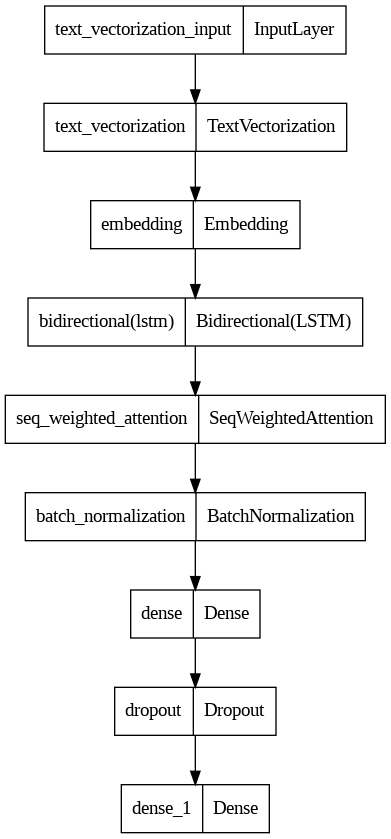

In [ ]:
tf.keras.utils.plot_model(attn_model)

In [ ]:
attn_model.fit(X_train,y_train,epochs = 10,batch_size = 40)

Epoch 1/10
165/165 [==============================] - 53s 221ms/step - loss: 0.6464 - auc: 0.6060 - binary_crossentropy: 0.6464 - acc: 0.6279
Epoch 2/10
165/165 [==============================] - 27s 167ms/step - loss: 0.4062 - auc: 0.8889 - binary_crossentropy: 0.4062 - acc: 0.8259
Epoch 3/10
165/165 [==============================] - 21s 126ms/step - loss: 0.2325 - auc: 0.9628 - binary_crossentropy: 0.2325 - acc: 0.9163
Epoch 4/10
165/165 [==============================] - 13s 79ms/step - loss: 0.1693 - auc: 0.9784 - binary_crossentropy: 0.1693 - acc: 0.9462
Epoch 5/10
165/165 [==============================] - 12s 69ms/step - loss: 0.1414 - auc: 0.9846 - binary_crossentropy: 0.1414 - acc: 0.9524
Epoch 6/10
165/165 [==============================] - 12s 74ms/step - loss: 0.1342 - auc: 0.9862 - binary_crossentropy: 0.1342 - acc: 0.9544
Epoch 7/10
165/165 [==============================] - 10s 63ms/step - loss: 0.1126 - auc: 0.9909 - binary_crossentropy: 0.1126 - acc: 0.9604
Epoch 8/10

In [ ]:
y_pred = attn_model.predict(X_dev)

89/89 [==============================] - 3s 11ms/step


In [ ]:
y_pred_cls = [1 if i > 0.5 else 0 for i in y_pred]
print(f1_score(y_dev,y_pred_cls))
print(classification_report(y_dev,y_pred_cls))


0.7457360272894255
              precision    recall  f1-score   support

           0       0.57      0.41      0.48      1078
           1       0.69      0.81      0.75      1751

    accuracy                           0.66      2829
   macro avg       0.63      0.61      0.61      2829
weighted avg       0.64      0.66      0.64      2829



In [ ]:
from numpy import dot
from numpy.linalg import norm

hello_enc = encoder("hello")
hi_enc = encoder("hi")
house_enc = encoder('house')



hello_emb = attn_model.trainable_weights[0][hello_enc[0],:]
hi_emb = attn_model.trainable_weights[0][hi_enc[0],:]
house_emb = attn_model.trainable_weights[0][house_enc[0],:]

print("hello, hi cos sim: ", dot(hello_emb,hi_emb)/(norm(hello_emb)*norm(hi_emb)))
print("hello, house cos sim: ", dot(hello_emb,house_emb)/(norm(hello_emb)*norm(house_emb)))


hello, hi cos sim:  0.019977571
hello, house cos sim:  -0.031320963


AttributeError: ignored

In [ ]:
!pip install trax

In [ ]:

# Layers used to build the Deep Learning Models
import trax.layers as tl
# Utilities to build and download datasets
import trax.data as data
# Utilities for training
import trax.supervised as ts
# To import models and other utilities:
import trax

In [ ]:
import itertools
# define the input stream 
def input_stream(input_file):

  for instance in open(input_file):
    instance = json.loads(instance)

    instance = (clean(instance['passage']) + " __SEP__ " + instance['question'] , 1 if instance['answer'] else 0)
    yield instance


train_input_stream = itertools.cycle(input_stream("train.jsonl"))
eval_input_stream = itertools.cycle(input_stream("dev.jsonl"))


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def tokenize(input_str):

    tknz = next(data.tokenize(iter([input_str]),vocab_file = "en_8k.subword"))
  
    return  tknz


def detokenize(integers):
 
    return trax.data.detokenize(integers, vocab_file='en_8k.subword')

In [ ]:
word = "president"

tokenized = tokenize(word)
print(f"tokenized: {tokenized}")

detokenized = detokenize(tokenized)


print(f"detokenized: {detokenized}")

tokenized: [4581]
detokenized: president


In [ ]:
data_pipeline = data.Serial(
    data.Tokenize(vocab_file='en_8k.subword', keys=[0]),
    data.FilterByLength(max_length=4096, length_keys=[0]),
    data.Batch(32),
    data.AddLossWeights(id_to_mask = 0)
)

train_batch_stream = data_pipeline(train_input_stream)
eval_batch_stream = data_pipeline(eval_input_stream)

In [ ]:
trax_model = tl.Serial(
    tl.Embedding(vocab_size=8192, d_feature=128),
    tl.LSTM(128),
    tl.Mean(axis=1),
    tl.Dense(128),
    tl.Dense(1),
    tl.Sigmoid()
)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Training task.
import os

train_task = ts.TrainTask(
    labeled_data=train_batch_stream,
    loss_layer=tl.BinaryCrossEntropyLoss(),
    optimizer=trax.optimizers.Adam(0.01),
    n_steps_per_checkpoint=50,
)

# Evaluaton task.
eval_task = ts.EvalTask(
    labeled_data=eval_batch_stream,
    metrics=[tl.BinaryCrossEntropy(), tl.Accuracy()],
    n_eval_batches=20  # For less variance in eval numbers.
)

# Training loop saves checkpoints to output_dir.
output_dir = os.path.expanduser('~/output-dir/')
!rm -rf {output_dir}
training_loop = ts.training.Loop(trax_model,
                              train_task,
                              eval_tasks=[eval_task],
                              output_dir=output_dir)

# Run 2000 steps (batches).
training_loop.run(100)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/jax/_src/xla_bridge.py:674: UserWarning: jax.host_count has been renamed to jax.process_count. This alias will eventually be removed; please update your code.
  warnings.warn(


LayerError: ignored

In [ ]:
inputs, targets, weights = next(eval_batch_stream)

example_input = inputs[0]
expected_class = targets[0]
example_input_str = detokenize(example_input)
print(f'example input_str: {example_input_str}')
sentiment_log_probs = trax_model(example_input[None, :])  # Add batch dimension.
print(f'Model returned class probabilities: {sentiment_log_probs}')
print(f'Expected class: {expected_class}')

example input_str: The return address is not required on postal mail However lack of a return address prevents the postal service from being able to return the item if it proves undeliverable such as from damage postage due or invalid destination Such mail may otherwise become dead letter mail  __SEP__ can you mail something with no return address<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><

433